# Load libraries and data

In [254]:
library(phyloseq); packageVersion("phyloseq")
library(dada2) ; packageVersion("dada2")
library(decontam) ; packageVersion("decontam")
library(ggplot2); packageVersion("ggplot2")
library(vegan); packageVersion("vegan")
library(DESeq2); packageVersion("DESeq2")
library(tidyr)
library(dplyr)
library(scales)
library(repr)
library(reshape2)
library(genefilter)
#library(VennDiagram)
#library(svglite)
#library(gridExtra)

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.28.0’

[1] ‘1.12.1’

[1] ‘1.4.0’

[1] ‘3.2.1’

[1] ‘2.5.6’

[1] ‘1.24.0’

In [255]:
ps_raw <- readRDS("~/data/awtp2_16S/phyloseq_object.rds")
ps_raw
sample_data(ps_raw)[sample_data(ps_raw)=="Low"] <- NA #sub NA for Low values
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[sample_data(ps_raw)$DNA_Ext_conc_ngperuL=="Low"] <- NA
sample_data(ps_raw)$DNA_Ext_conc_ngperuL <- as.numeric(as.character(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)) #convert from factor to decimal
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[is.na(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)] <- 0.02

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 186 samples ]
sample_data() Sample Data:       [ 186 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

# Visualize number of reads per sample

In [256]:
#remove samples with too few reads
ps <- prune_samples(sample_sums(ps_raw)>=1000, ps_raw) #remove failed samples
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


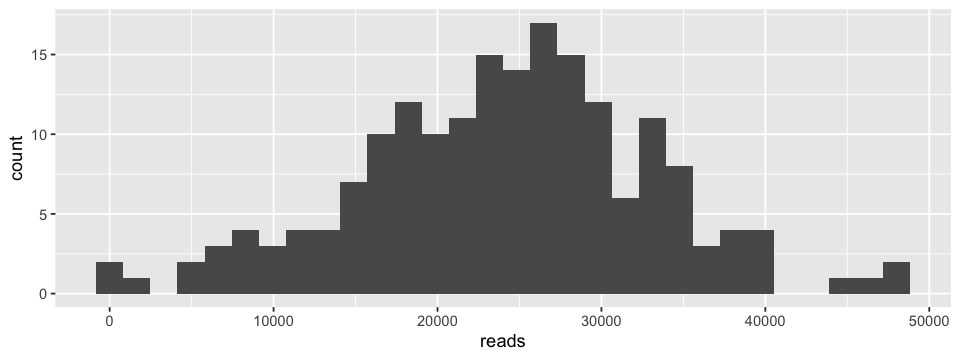

In [209]:
read_counts <- as.data.frame(rowSums(otu_table(ps_raw)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram()

# Number of ASVs per sample, including controls

In [257]:
sample_data(ps)$project_type <- factor(sample_data(ps)$project_type,
                                       levels=c('Experimental', 'ECAWPC', 'DPWF', 'Pipe_Loop', 'Full_Scale'))

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

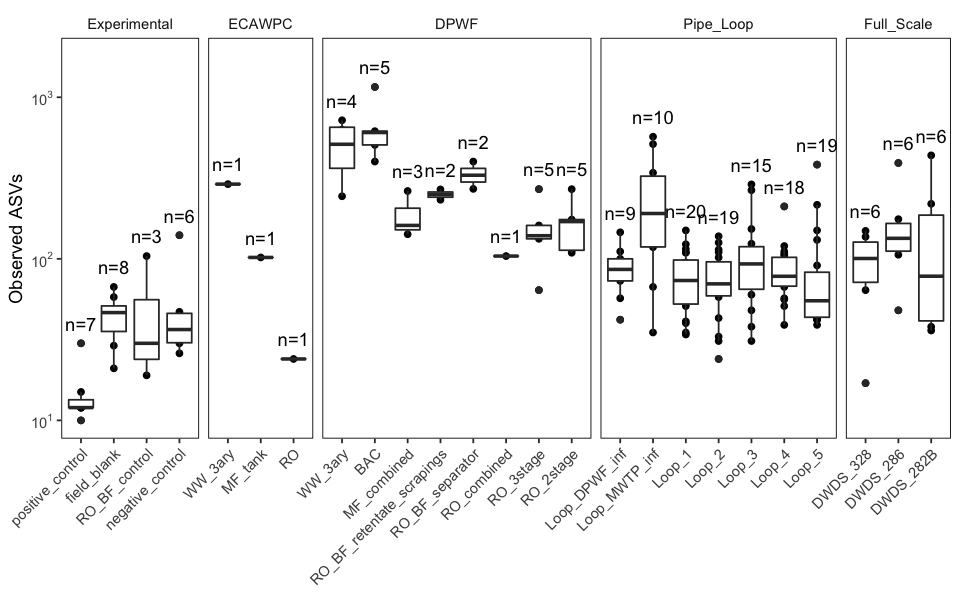

In [55]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
#ps_bulk_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Bulk")
options(repr.plot.width = 8, repr.plot.height = 5)
plot_richness(ps, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
    # strip.text.x = element_blank(),
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    #geom_vline(xintercept=4.5, linetype='solid')+
    #geom_vline(xintercept=12.5, linetype='solid')+
    #geom_vline(xintercept=19.5, linetype='solid')
    facet_grid(.~project_type, scale="free_x", space="free_x")

# Positive controls

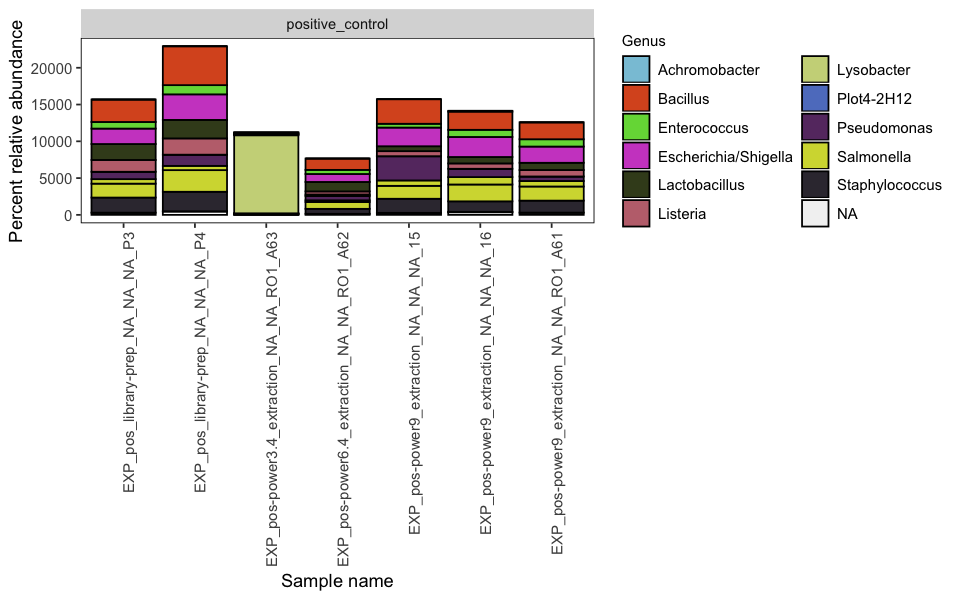

In [56]:
ps_mock <- subset_samples(ps, subset = location_code %in% c("positive_control"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 10, TRUE) #keep only seqs that had reads in mock(s)
plot_bar(ps_mock, x="sample_code_full_and_batch", fill="Genus") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

In [21]:
#make table of mock sequences
ps_mock <- subset_samples(ps, subset = location_code %in% c("positive_control"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads in mock(s)
mock_tax <- as.data.frame(tax_table(ps_mock))
mock_otu <- as.data.frame(otu_table(ps_mock))
mock_otu <- t(mock_otu)
mock_tab <- merge(mock_otu, mock_tax, by=0)
mock_tab <- mock_tab[order(-mock_tab$SD037), ]

In [22]:
# load reference sequences for mock controls and compare:
mock.ref <- getSequences("~/data/refs/ZymoBIOMICS.STD.refseq.v2/ssrRNAs/zymo_mock_16S_18S.fasta")
# identify matches to references, anything else is contamination
match.ref <- sapply(row.names(mock_otu), function(x) any(grepl(x, mock.ref)))
mock_contam <- row.names(as.data.frame(match.ref[match.ref==FALSE]))

In [23]:
#make table with just rows that are contaminants
mock_contam_tab <- mock_tab[mock_tab$Row.names %in% mock_contam, ]

In [24]:
#get only the ones that are found in two or more mocks with at least 1 read (consistent contamination)
mock_consistent_tax <- row.names(tax_table(filter_taxa(ps_mock, filterfun(kOverA(2, 1)), TRUE)))
mock_contam_tab[mock_contam_tab$Row.names %in% mock_consistent_tax,]

,Row.names,SD037,SD039,SD049,SD114,SD119,SD150,SD167,Kingdom,Phylum,Class,Order,Family,Genus
,<I<chr>>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
10,AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA,610,745,0,233,1004,734,580,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Salmonella
3,AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,2,0,2,0,0,2,4,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Microvirga
20,AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATATAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGTATAGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,2,0,4,0,0,0,0,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Acidovorax
22,AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA,0,0,10613,195,0,5,0,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Lysobacter


**There is a Salmonella enterica ASV (one mismatch) that isn't in the ref sequences and is abundant in all mock controls (except SD049, which failed).** Similarly, the Zymo mock community we sequenced with the El Paso study also had a Salmonella ASV that didn't match to the reference sequence (1 nt mismatch). It was a different one from this one though. Perhaps this is variable in Zymo's stock or there is error during PCR of this sequence (or sequencing error not corrected by DADA2).

# Negative controls

In [ ]:
# plot heatmap showing ASVs that are present in both negative controls and samples

In [258]:
ps
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

In [259]:
ps_samp <- subset_samples(ps, subset = !(location_code %in% c("negative_control",
                                                              "field_blank",
                                                              "RO_BF_control",
                                                              "positive_control")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps, subset = location_code %in% c("negative_control", "field_blank", "RO_BF_control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

#merge samples and blanks  back together and filter for only taxa that occur in at least one sample
ps_samp_blank <- merge_phyloseq(ps_samp, ps_blank)
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_samp_blank
ps_samp
ps_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7123 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7123 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6974 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 6974 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 371 taxa and 18 samples ]
sample_data() Sample Data:       [ 18 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 371 taxa by 6 taxonomic ranks ]

In [260]:
location_levels = c(
    'field_blank',
    'RO_BF_control',
    'negative_control',
    'WW_3ary',
    'BAC',
    'MF_combined',
    'MF_tank',
    'RO_BF_retentate_scrapings',
    'RO_BF_separator',
    'RO_combined',
    'RO_3stage', 'RO_2stage', 'RO',
    'Loop_DPWF_inf', 'Loop_MWTP_inf', 'Loop_1', 'Loop_2', 'Loop_3', 'Loop_4', 'Loop_5',
    'DWDS_328', 'DWDS_286', 'DWDS_282B')
sample_data(ps_samp_blank)$location_code <- factor(sample_data(ps_samp_blank)$location_code, 
                            levels=location_levels)


In [261]:
#for later: Get bulk-only taxa and intersecting taxa.

blank_taxa <- row.names(tax_table(ps_blank))
samp_taxa <- row.names(tax_table(ps_samp))
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

ps_samp_only <- prune_taxa(samp_only_taxa, ps_samp_blank)
ps_intersecting <- prune_taxa(intersecting_taxa, ps_samp_blank)

ps_samp_and_intersecting <- prune_taxa(c(intersecting_taxa, samp_only_taxa), ps_samp_blank)
ps_samp_and_intersecting <- filter_taxa(ps_samp_and_intersecting, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

In [262]:
length(blank_taxa)
length(samp_taxa)
length(intersecting_taxa)

[1] 371

[1] 6974

[1] 222

In [263]:
ps_samp_and_intersecting

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6974 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 6974 taxa by 6 taxonomic ranks ]

In [264]:
# normalize to percent
#ps_samp_blank_perc <- transform_sample_counts(ps_samp_blank, function(OTU) 100*OTU/sum(OTU))
#
ps_intersecting_perc <- prune_taxa(intersecting_taxa, ps_perc)
ps_intersecting_perc <- filter_taxa(ps_intersecting_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
ps_intersecting_perc_filt5 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 5)), TRUE)
ps_intersecting_perc_filt2 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 2)), TRUE)
ps_intersecting_perc_filt1 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 1)), TRUE)

#ps_blank_perc <- prune_taxa(blank_taxa, ps_samp_blank_perc)
#ps_blank_perc <- filter_taxa(ps_blank_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
#ps_blank_perc_filt2 <- filter_taxa(ps_blank_perc, filterfun(kOverA(2, 2)), TRUE)
#ps_blank_perc_filt1 <- filter_taxa(ps_blank_perc, filterfun(kOverA(2, 1)), TRUE)


In [265]:
ps_intersecting_perc_filt2
ps_intersecting_perc_filt5

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 58 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 58 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 45 taxa and 183 samples ]
sample_data() Sample Data:       [ 183 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 45 taxa by 6 taxonomic ranks ]

**Major contaminants are clostridiaceae_1, peptostreptococcaceae, and Family XI, Xanthomonadaceae**

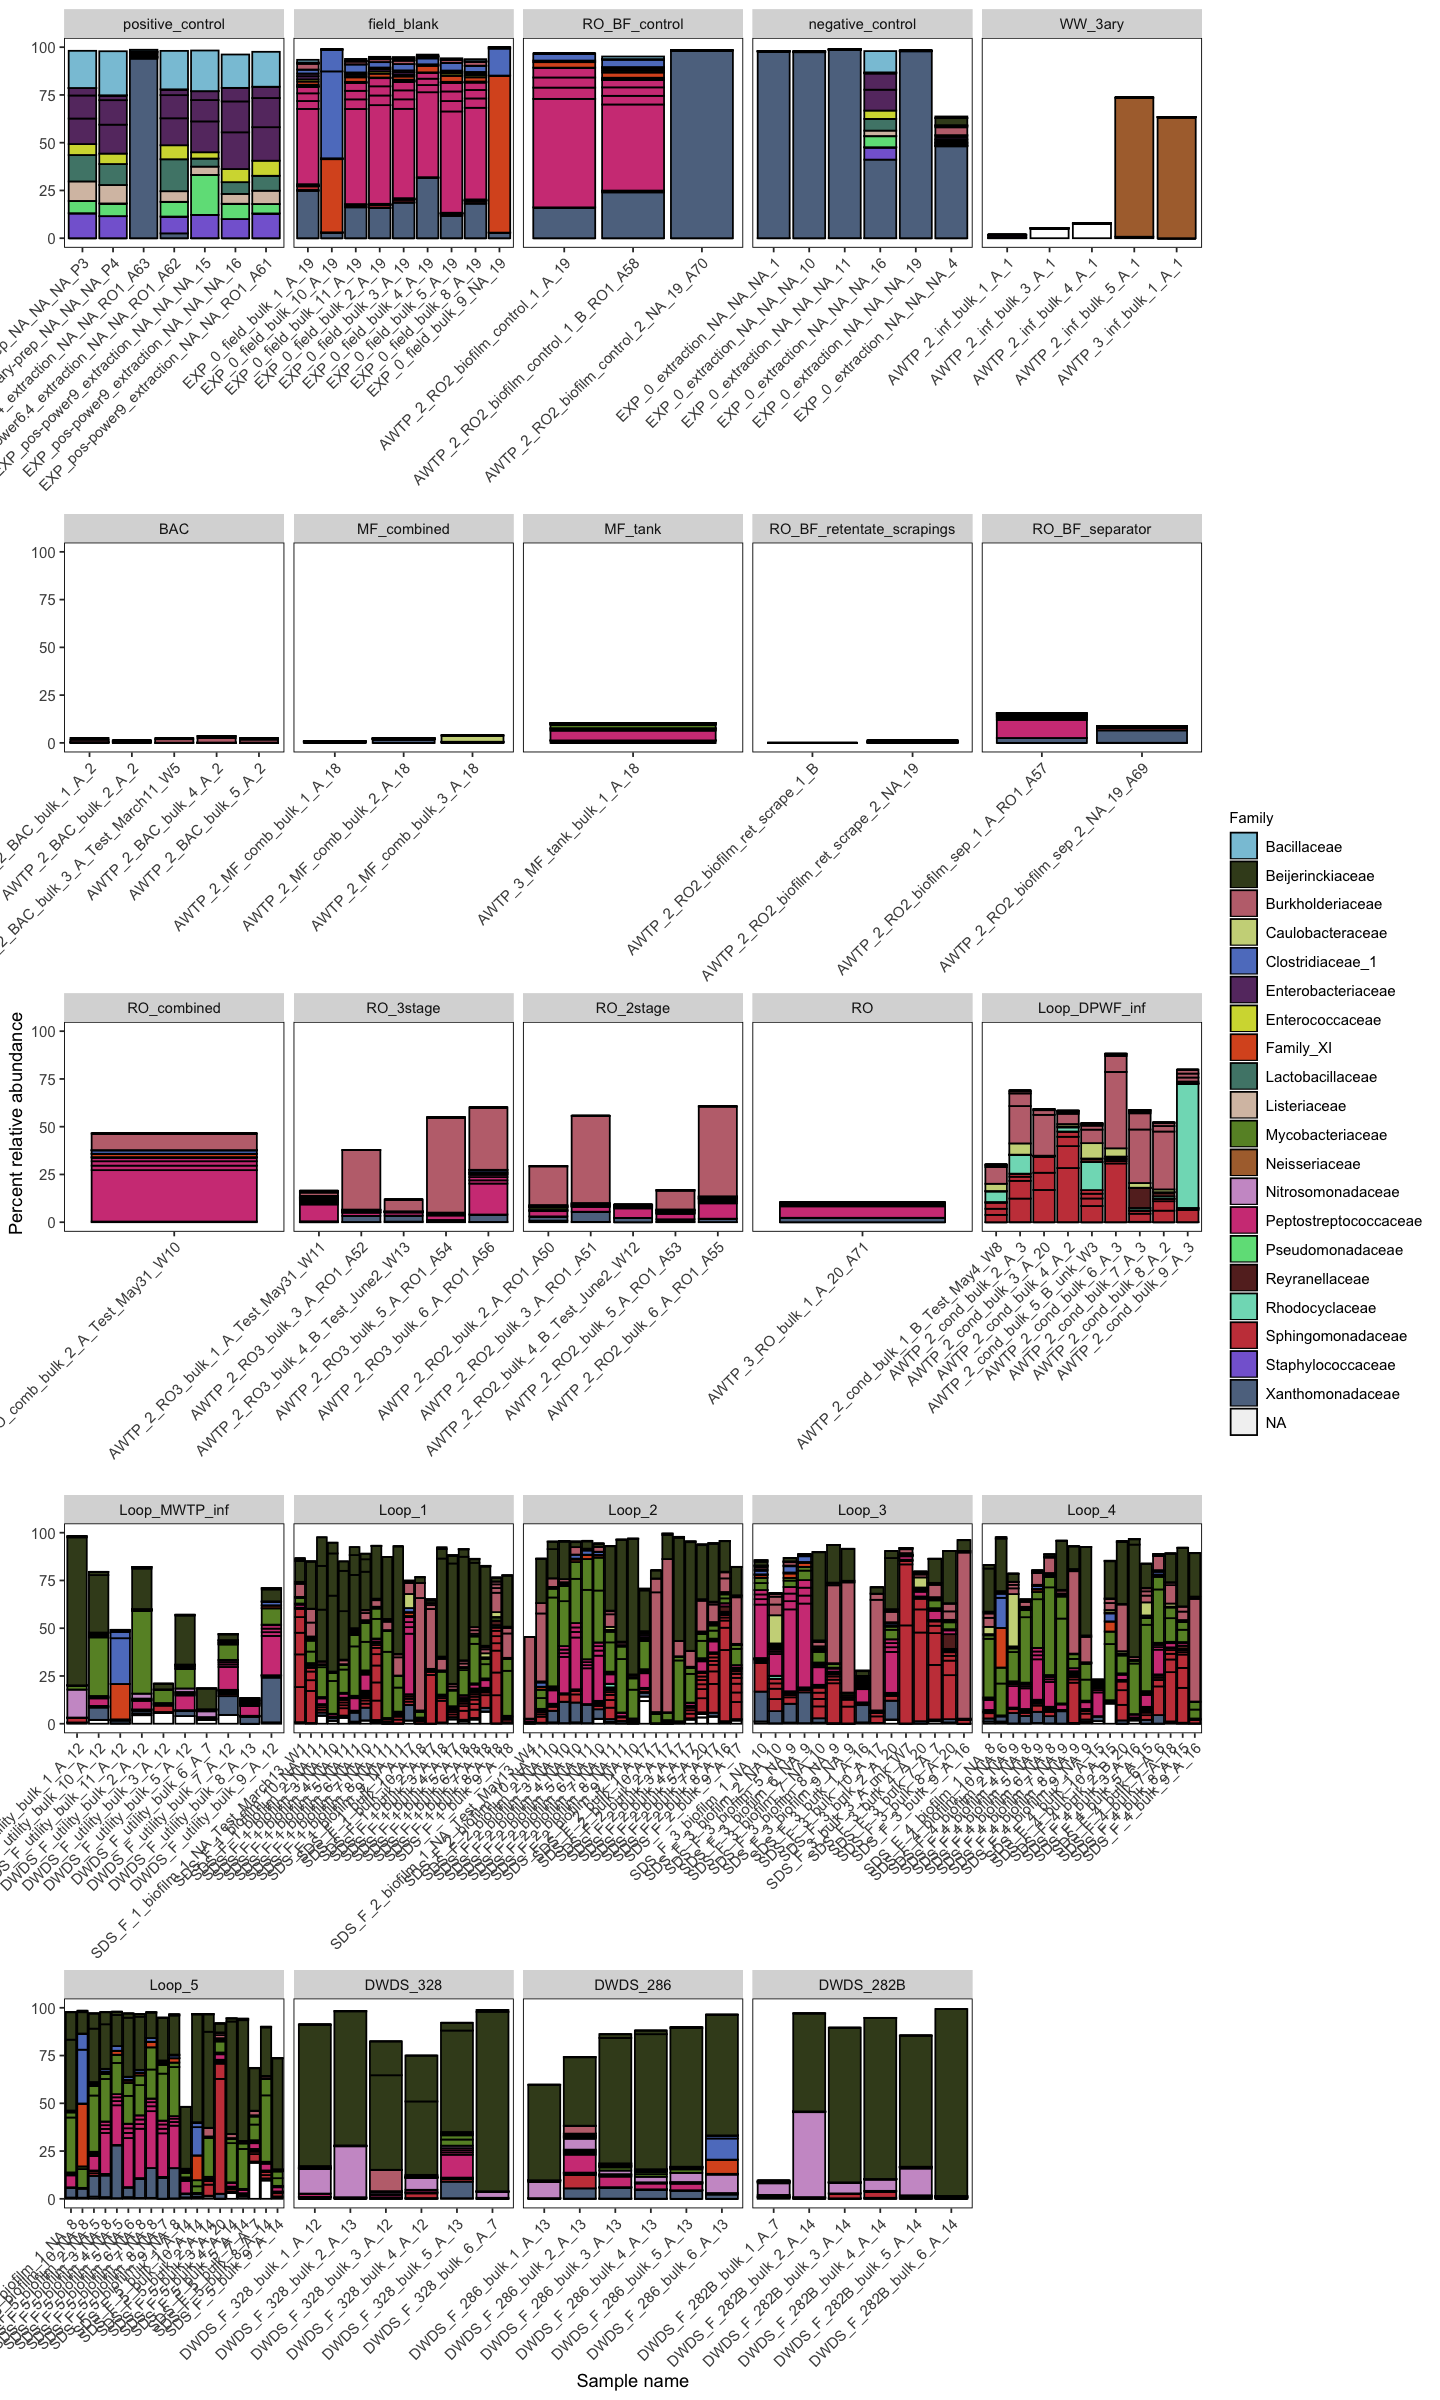

In [237]:
options(repr.plot.width = 12, repr.plot.height = 20)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_intersecting_perc_filt5, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_wrap(~location_code, nrow=5, scale="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=1))


Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

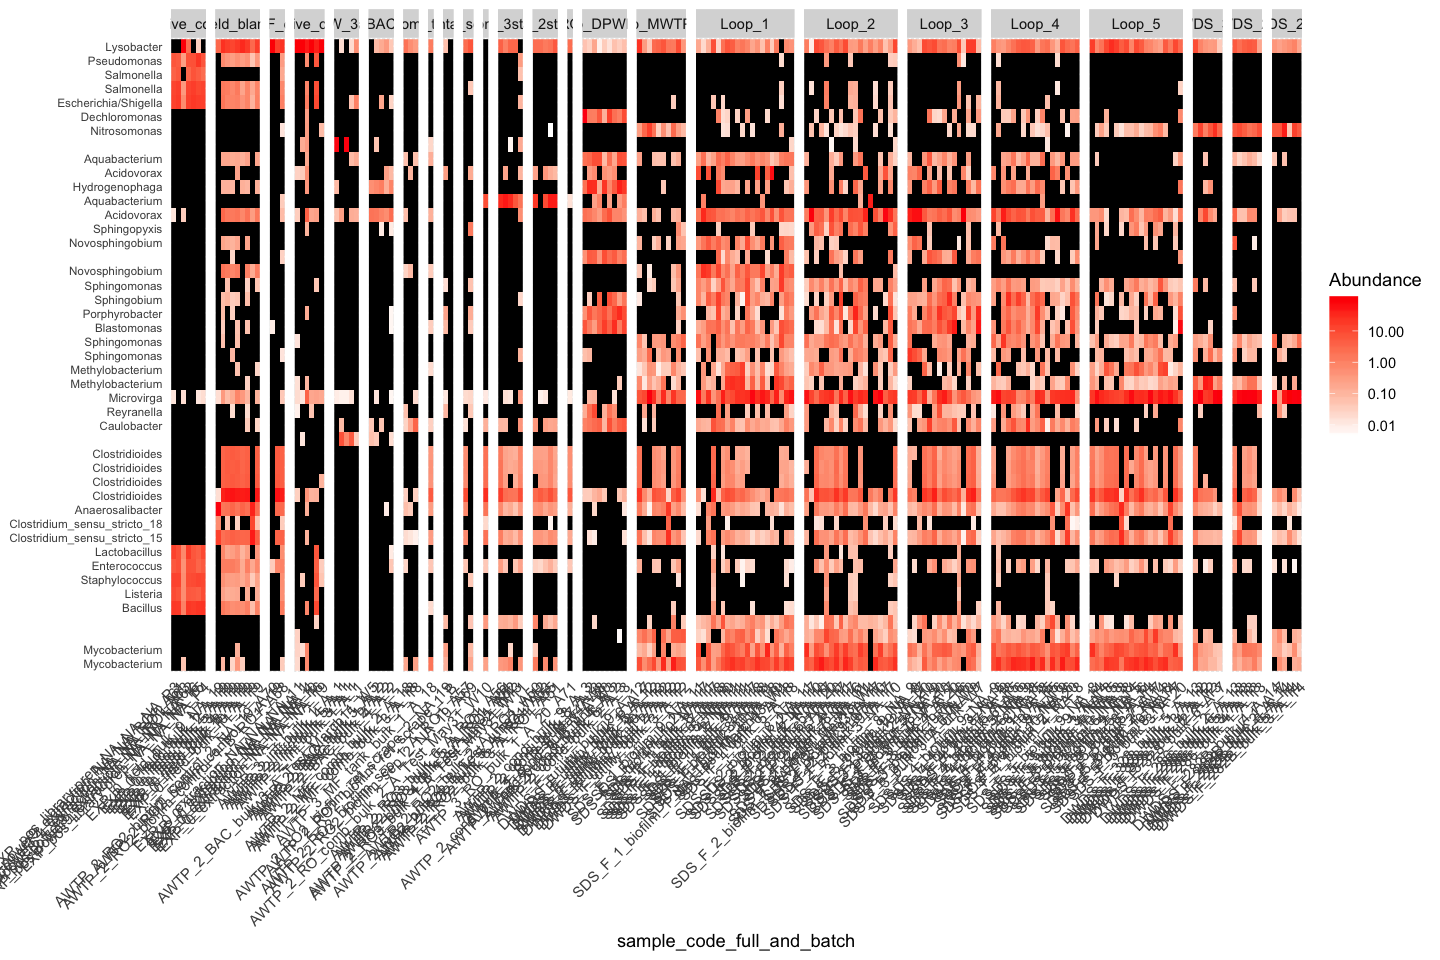

In [238]:
#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_intersecting_perc_filt5, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
ggsave('~/data/awtp2_16S/heatmap_intersction_samples_blanks_gr5reads_genus.png', device='png', width=20, height=9)

In [ ]:
# Look for consistent members of the negative controls and try removing those


In [ ]:
# also remove cross-contamination from positive control

# Using Decontam

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

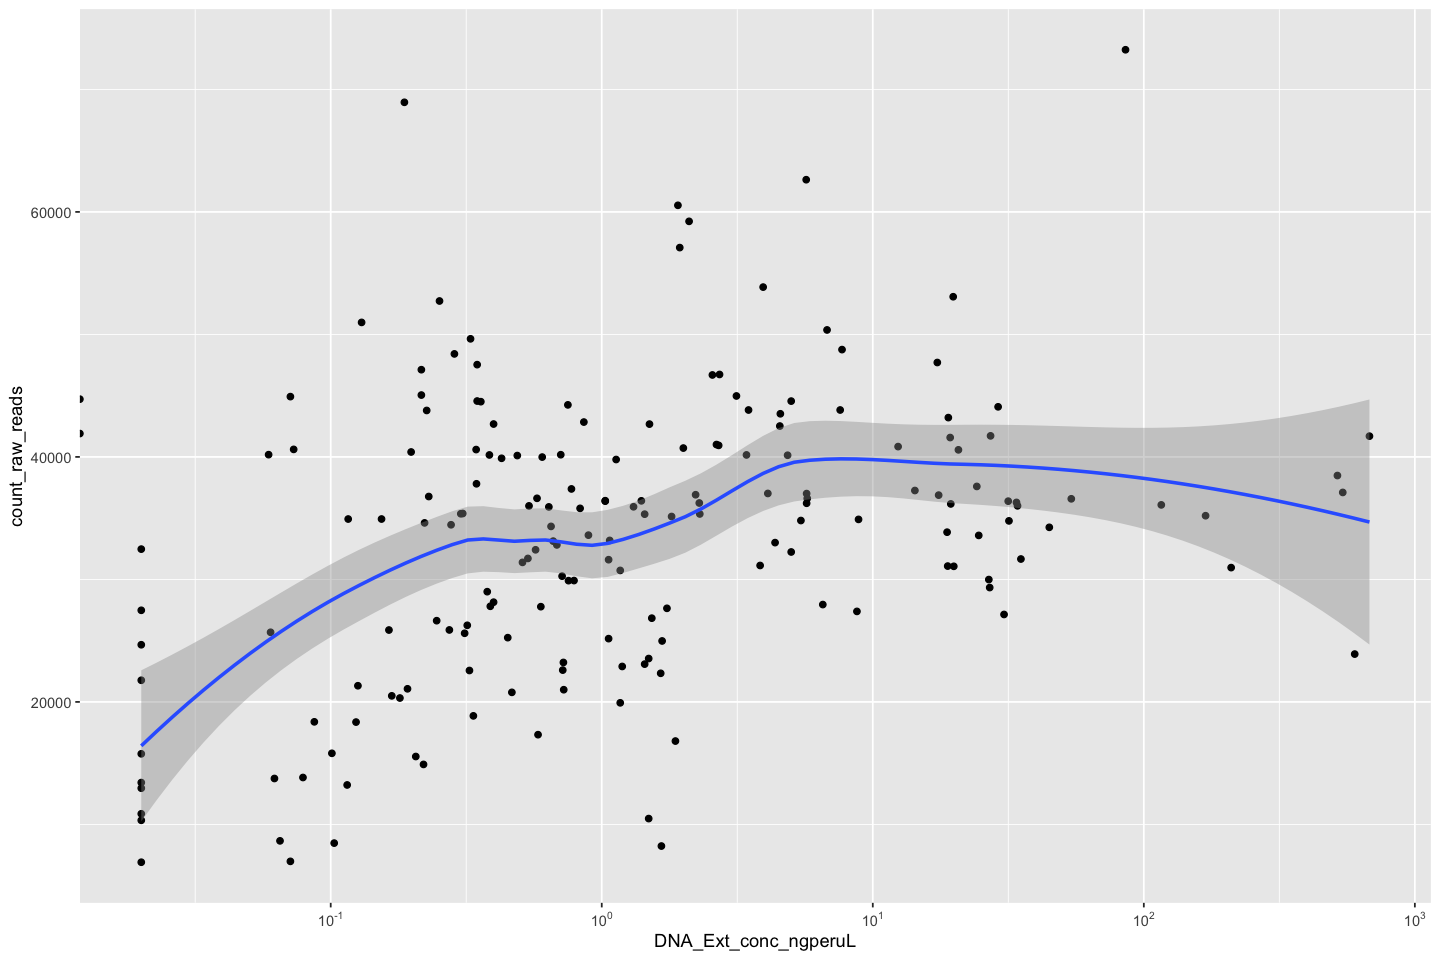

In [239]:
ggplot(sample_data(ps), aes(x=DNA_Ext_conc_ngperuL, y=count_raw_reads))+
    geom_point()+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x))) + 
    geom_smooth(method = loess) 
    #scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))


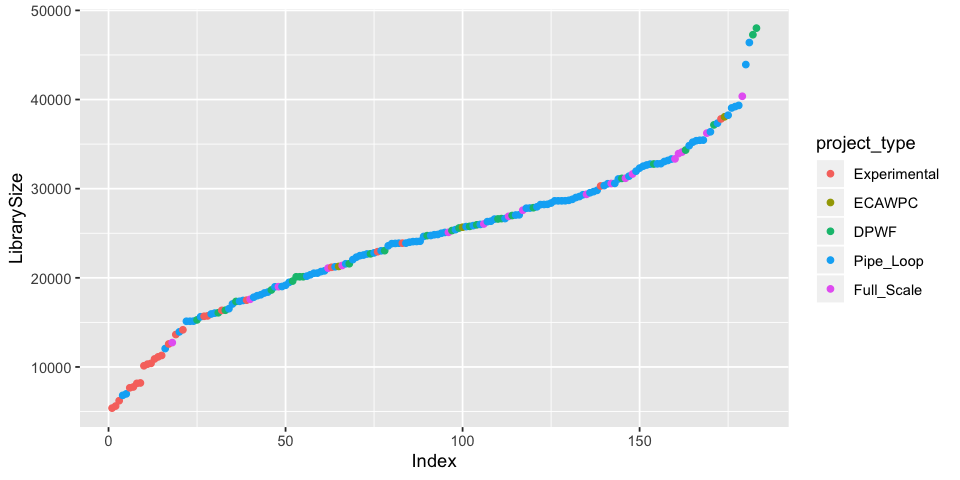

In [240]:
df <- as.data.frame(sample_data(ps)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=project_type)) + geom_point()


## Frequency method

In [241]:
contamdf.freq <- isContaminant(ps_samp, method="frequency", conc="DNA_Ext_conc_ngperuL")

In [242]:
head(contamdf.freq)

,freq,prev,p.freq,p.prev,p,contaminant
,<dbl>,<int>,<dbl>,<lgl>,<dbl>,<lgl>
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,0.211343299,138,0.891762104,NA,0.891762104,FALSE
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACA,0.004140335,94,0.999866881,NA,0.999866881,FALSE
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA,0.080015705,128,0.961608932,NA,0.961608932,FALSE
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTTGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA,0.001434974,25,0.635910104,NA,0.635910104,FALSE
AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG,0.055666960,132,0.008389675,NA,0.008389675,TRUE
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA,0.028645518,151,0.003579763,NA,0.003579763,TRUE


In [244]:
table(contamdf.freq$contaminant)
head(which(contamdf.freq$contaminant))


FALSE  TRUE 
 6896    78 

[1]   5   6  26 115 469 583

In [247]:
decontam_freq_contams <- row.names(contamdf.freq[contamdf.freq$contaminant==TRUE,])

In [248]:
intersect(decontam_freq_contams, intersecting_taxa)

[1] "AGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGTCAGGAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTCTTGAAACTGGGAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTAGCGAAGGCGGCTCTCTGGACTGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAG"
[2] "AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA"
[3] "AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTGAATGAGTTATCTGTGAAATTCCTGGGCTTAACCTGGGGTGGTCAGATGATACTGTTTGACTCGAGTATGGGAGAGGGTAGTAGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGAACACCGGTGGCGAAGGCGGCTACCTGGCCTGATACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA"
[4] "ATGTGGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGAATGCGTAGGCGGCTTGACAAGTCAGGAGTGAAATCCCCAGGCTCAACCTGGGAACTGCTTTTGAAACTGTCTTGCTAGAGTCCCGGAGGGGTTGGCGGAATTCCGAGTGTAGAGGTGGAATTCGCAGATATTCGGAGGAACACCAGTGGCGTAGGCGGCCAACTGGACGGGAACTGACGCTGAGGCATGAAAGTGTGGGGAGCAAACA"

**The decontam frequency method identified just 4 of the same ASVs as were identified by the intersection of negative controls and samples. Probably not the best method.**

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1 rows containing missing values (geom_path).”

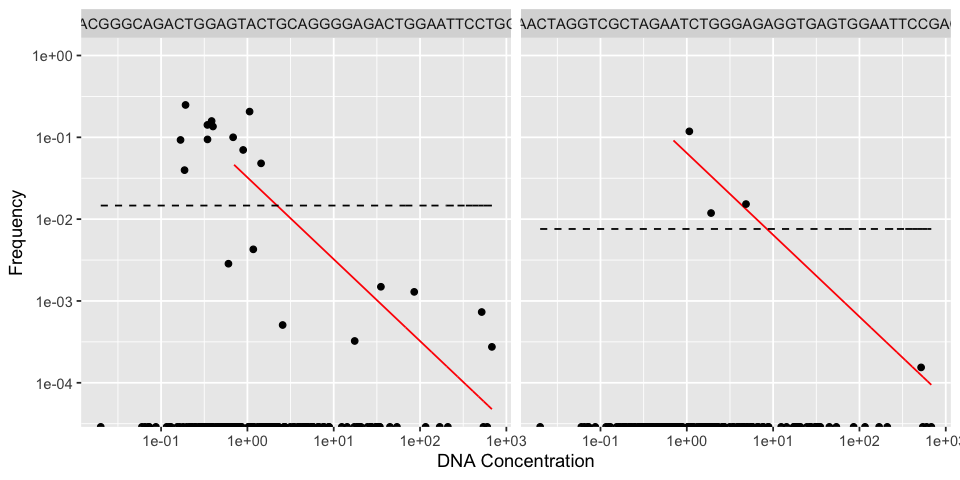

In [253]:
# expected contaminants should follow the red line
plot_frequency(ps_samp, taxa_names(ps_samp)[c(26,115)], conc="DNA_Ext_conc_ngperuL") + 
  xlab("DNA Concentration")


## Prevalence method

In [266]:
sample_data(ps)$is.neg <- sample_data(ps)$sample_or_control == "control"
contamdf.prev <- isContaminant(ps, method="prevalence", neg="is.neg")
table(contamdf.prev$contaminant)


FALSE  TRUE 
 7198    73 

In [269]:
decontam_prev_contams <- row.names(contamdf.prev[contamdf.prev$contaminant==TRUE,])

In [272]:
length(intersect(decontam_prev_contams, intersecting_taxa))

[1] 67

Warning message:
“Transformation introduced infinite values in discrete y-axis”

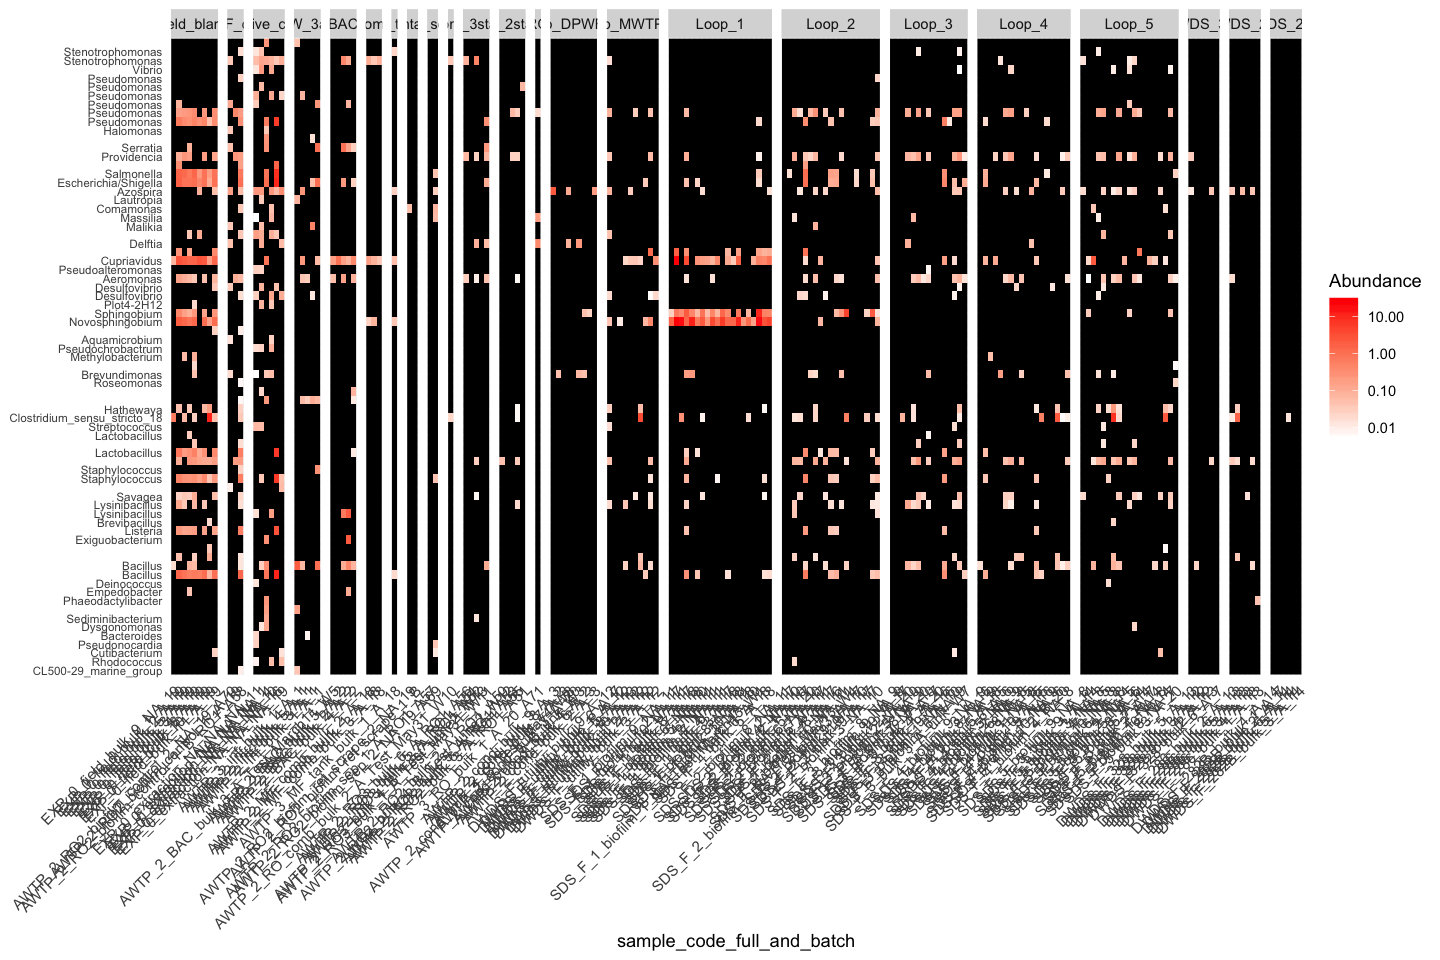

In [276]:
ps_decontam_prev_contams <- prune_taxa(decontam_prev_contams, ps_samp_blank_perc)
sample_data(ps_decontam_prev_contams)$location_code <- factor(sample_data(ps_decontam_prev_contams)$location_code, 
                            levels=location_levels)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_prev_contams, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
ggsave('~/data/awtp2_16S/heatmap_intersction_samples_blanks_gr5reads_genus.png', device='png', width=20, height=9)

## DESeq2 method

In [ ]:
#run DESeq on the bulk and blank taxa
# solution to having zeros in the otu table found here: https://support.bioconductor.org/p/63229/
# review this solution again in the future!

diagddsraw = phyloseq_to_deseq2(ps_samp_blank, ~ sample_or_control) # types are "Experimental" for controls and "DPWF" for samples
gm_mean = function(x, na.rm=TRUE){  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))}

geoMeans = apply(counts(diagddsraw), 1, gm_mean)
diagdds = estimateSizeFactors(diagddsraw, geoMeans = geoMeans)

dds = DESeq(diagdds, test="Wald", fitType="local")

#analyze results of DESeq filtering for significance
res = results(dds, cooksCutoff = FALSE)
alpha = 0.01
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_dpwf_blank)[rownames(sigtab), ], "matrix"))
sigtab
significant_taxa <- row.names(sigtab[sigtab$log2FoldChange < 0,]) #remove anything significantly enriched in blanks

In [279]:
unique(sample_data(ps_samp_blank)$sample_or_control)

[1] sample  control
Levels: sample control